# 拡散モデル

Train Data: [ 7.81347860e-01  9.43535922e-02  9.44689681e-01  1.89173673e+00
 -9.39046944e-03 -9.37270677e-03  1.95252205e+00  1.07424517e+00
 -2.63988377e-01  8.30949329e-01 -2.57435535e-01 -2.59936994e-01
  5.05727355e-01 -1.82606713e+00 -1.62227455e+00 -3.64404536e-01
 -8.51855508e-01  5.83933824e-01 -7.38462937e-01 -1.28405186e+00
  1.82965513e+00 -3.27166676e-04  3.17004095e-01 -1.29751577e+00
 -3.45033015e-01  3.63953237e-01 -1.00133588e+00  6.50418393e-01
 -4.05897326e-01 -7.16444051e-02 -4.07052730e-01  2.24795624e+00
  2.29341269e-01 -9.00411756e-01  1.13386984e+00 -1.07690789e+00
  4.69917319e-01 -1.87625714e+00 -1.19304351e+00  4.56931758e-01
  1.04290403e+00  4.29350485e-01  1.18822257e-01 -8.18251897e-02
 -1.35569458e+00 -5.34867856e-01 -2.54428971e-01  1.38766313e+00
  6.15710774e-01 -1.66351975e+00]
Epoch 1, Loss: 0.6274144530296326
Epoch 2, Loss: 1.359542191028595
Epoch 3, Loss: 0.6195549488067627
Epoch 4, Loss: 1.040593421459198
Epoch 5, Loss: 0.6062563180923461
Epoch 

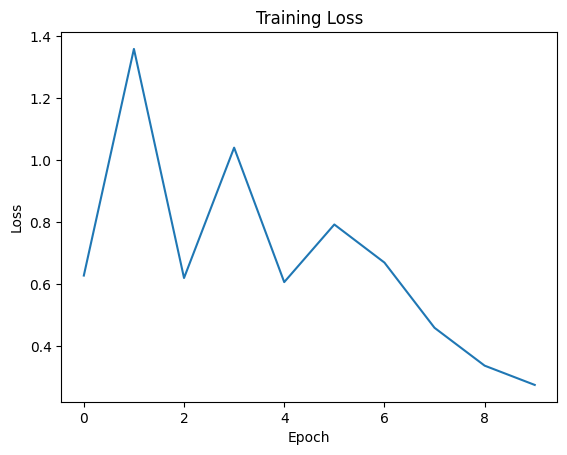

Generated Samples: [-0.23064318 -0.2537656  -0.2165823  -0.5828494  -0.19241174 -0.48042095
 -0.32937235 -0.25692916 -0.2117502  -0.6381962  -0.41200447 -0.17673963
 -0.21220618 -0.40720174 -0.23586851 -0.42724407 -0.22420605 -0.2405487
 -0.5842531  -0.33882543 -0.40180084 -0.6808384  -0.2279753  -0.23859379
 -0.4865814  -0.31668234 -0.22720955 -0.34074306 -0.3515924  -0.3331444
 -0.2895569  -0.12804246 -0.18878776 -0.3116264  -0.7846899  -0.23222922
 -0.18656571 -0.24945559 -0.24794893 -0.40341774 -0.4540408  -0.24924554
 -0.3498781  -6.325163   -0.18774131 -0.25725505 -0.29620183 -0.29829627
 -0.35619327 -0.28201997]


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

# ハイパーパラメータ
num_timesteps = 1000 # 拡散ステップ数
epochs = 10          # 学習エポック数
lr = 1e-3            # 学習率
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Pytorchの組み込み演算により効率的に計算
# 高次元データ用のtorch.arrangeやtorch.expを活用してコードを簡潔に

# 時間埋め込み（正弦波位置エンコーディング）
def pos_encoding(timesteps, output_dim, device='cpu'):
    position = timesteps.view(-1, 1).float()  # 必要に応じて型変換
    div_term = torch.exp(torch.arange(0, output_dim, 2, device=device, dtype=torch.float32) * 
                         (-np.log(10000.0) / output_dim))
    sinusoid = torch.cat([torch.sin(position * div_term), torch.cos(position * div_term)], dim=1)
    return sinusoid

# Dropoutの導入: 過学習を防ぐために、各隠れ層にnn.Dropoutを追加。
# Batch Normalizationの導入: 学習を安定させるためにnn.BatchNorm1dを適用。
# 活性化関数の選択: F.reluの代わりにnn.LeakyReLUやnn.ELUを試すことで、勾配消失問題に対応。

# 拡散モデル
class DiffusionModel(nn.Module):
    def __init__(self, time_embed_dim=16):
        super(DiffusionModel, self).__init__()
        self.time_embed_dim = time_embed_dim  # time_embed_dimをインスタンス変数として初期化
        self.fc1 = nn.Linear(1 + time_embed_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x, t):
        # 時間埋め込み
        t_embed = pos_encoding(t, self.time_embed_dim, x.device)
        x_t = torch.cat([x, t_embed], dim=1)  # 時間情報と入力データを結合
        x_t = F.relu(self.fc1(x_t))
        x_t = F.relu(self.fc2(x_t))
        return self.fc3(x_t)

# 拡散プロセス
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        t_idx = t - 1 # alphas[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx].view(-1, 1)  # (N, 1)
        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def denoise(self, model, x, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()
        
        t_idx = t - 1 # alphas[0] is for t=1
        alpha = self.alphas[t_idx].view(-1, 1)
        alpha_bar = self.alpha_bars[t_idx].view(-1, 1)
        model.eval()
        with torch.no_grad():
            eps = model(x, t)

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # no noise at t=1

        mu = (x - (1 - alpha) / torch.sqrt(1 - alpha_bar) * eps) / torch.sqrt(alpha)

        return mu

# モデルとオプティマイザ
time_embed_dim = 16
model = DiffusionModel(time_embed_dim=time_embed_dim).to(device)
optimizer = Adam(model.parameters(), lr=lr)
diffuser = Diffuser(num_timesteps=num_timesteps, device=device)

# 1. 乱数生成用のシード値を設定
np.random.seed(42)

# 2. らんだむな整数をシード値として固定
random_seed = np.random.randint(0, 10000)

# 学習データ(ガウスノイズ)
data = np.random.randn(50)  # shape: (50,)
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, 1)).flatten()
print("Train Data:", data)
train_data = torch.tensor(data, dtype=torch.float32).view(-1, 1).to(device) 

# データローダー作成
batch_size = 10
dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# 学習ループ
losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    for batch in dataloader:
        optimizer.zero_grad()
        x = batch.to(device)
        t = torch.randint(1, num_timesteps + 1, (len(x),), device=device)

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise_pred, noise)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
    avg_loss = loss_sum / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

# 学習曲線のプロット
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# サンプリング
model.eval()
with torch.no_grad():
    samples = torch.randn((50, 1), device=device)  # ランダムなノイズから開始
    for t in range(num_timesteps, 0, -1):
        t_tensor = torch.tensor([t] * len(samples), device=device)
        samples = diffuser.denoise(model, samples, t_tensor)

# サンプル結果の表示
print("Generated Samples:", samples.cpu().numpy().flatten())

In [8]:
print(len(samples.cpu().numpy().flatten()), len(data))

50 50


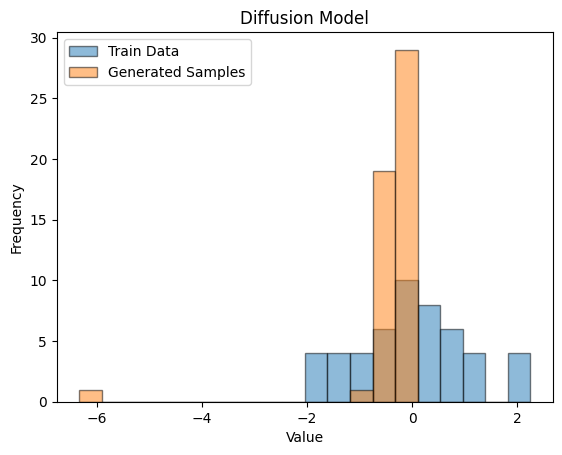

In [9]:
# 共通のビン境界を定義
min_value = min(data.min(), samples.cpu().numpy().min())  # 最小値
max_value = max(data.max(), samples.cpu().numpy().max())  # 最大値
bins = np.linspace(min_value, max_value, 21)  # 20個の区間に分ける（ビン境界を21個）


# ヒストグラムのプロット
plt.hist(data, bins=bins, alpha=0.5, label='Train Data', edgecolor='black')
plt.hist(samples.cpu().numpy().flatten(), bins=bins, alpha=0.5, label='Generated Samples', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Diffusion Model')
plt.legend()
plt.show()

In [10]:
# 学習データ(ガウスノイズ)
data = np.random.randn(50)  # shape: (50,)
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, 1)).flatten()
print("Train Data:", data)

# PyTorchテンソルに変換
train_data = torch.tensor(data, dtype=torch.float32).view(-1, 1)

# 必要ならCPUに移動
train_data = train_data.cpu()

# NumPy配列に変換
train_data_np = train_data.numpy()

# 重複ありのサンプリング
sampled_data = np.random.choice(train_data_np.flatten(), size=50, replace=True)

print("元データ:", train_data_np.flatten())
print("サンプリングデータ:", sampled_data)


Train Data: [ 0.3538877  -0.46544848 -0.80262589  0.68615787  1.17062353  1.05541258
 -0.99013424 -0.37779208  0.3621825   1.10655422 -0.57415775 -0.2350445
 -1.29874875 -1.40258208  0.91820964  1.54639058 -0.10374014  1.13888992
  0.39727351 -0.76588312  0.39699574  1.75642945 -0.06193481  1.78716999
 -3.04726916  0.92904301  0.08002679 -0.3660017   0.08547278 -2.31688356
 -0.27434136  0.39204733  1.68694371 -0.61932734 -0.95463732 -0.60024882
  1.03706791  0.35927988 -0.63260231  0.57246106  0.09161552  1.09858213
 -0.83166113 -0.39910805 -0.47356583 -1.71141711  0.32157981  0.28106741
 -0.01463531 -0.29157371]
元データ: [ 0.3538877  -0.46544847 -0.8026259   0.6861579   1.1706235   1.0554125
 -0.99013424 -0.3777921   0.3621825   1.1065543  -0.5741578  -0.2350445
 -1.2987487  -1.402582    0.9182097   1.5463905  -0.10374014  1.1388899
  0.3972735  -0.76588315  0.39699575  1.7564294  -0.06193481  1.7871699
 -3.047269    0.929043    0.0800268  -0.3660017   0.08547278 -2.3168836
 -0.27434137 

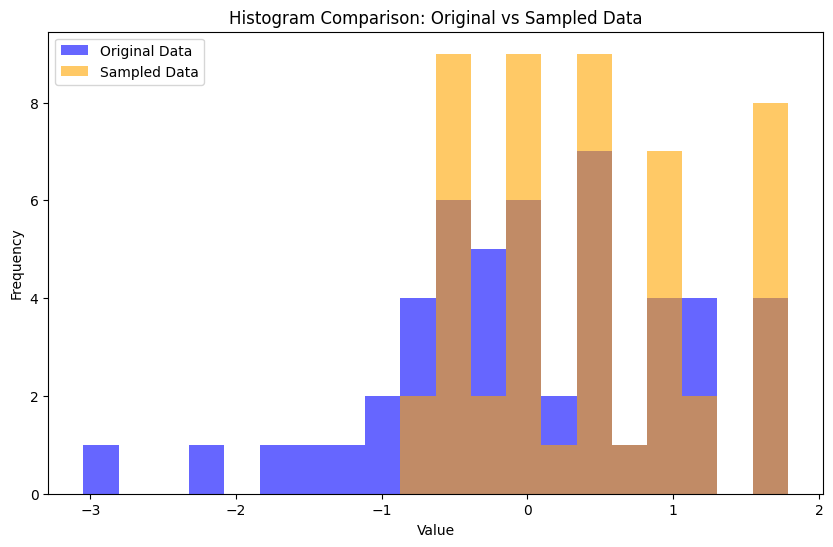

In [11]:
# 共通のビン境界を定義
min_value = min(train_data_np.min(), sampled_data.min())  # 最小値
max_value = max(train_data_np.max(), sampled_data.max())  # 最大値
bins = np.linspace(min_value, max_value, 21)  # 20個の区間に分ける（ビン境界を21個）

# ヒストグラムのプロット
plt.figure(figsize=(10, 6))

# 元データのヒストグラム
plt.hist(train_data_np.flatten(), bins=bins, alpha=0.6, color='blue', label='Original Data')

# サンプリングデータのヒストグラム
plt.hist(sampled_data, bins=bins, alpha=0.6, color='orange', label='Sampled Data')

# グラフの装飾
plt.title('Histogram Comparison: Original vs Sampled Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper left')

# 表示
plt.show()

In [12]:
import statistics
print("sampled_data", statistics.pvariance(sampled_data))

sampled_data 0.60162467


# 拡散モデル 複数学習データバージョン

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

# ハイパーパラメータ
num_timesteps = 1000 # 拡散ステップ数
epochs = 10          # 学習エポック数
lr = 1e-3            # 学習率
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Pytorchの組み込み演算により効率的に計算
# 高次元データ用のtorch.arrangeやtorch.expを活用してコードを簡潔に

# 時間埋め込み（正弦波位置エンコーディング）
def pos_encoding(timesteps, output_dim, device='cpu'):
    position = timesteps.view(-1, 1).float()  # 必要に応じて型変換
    div_term = torch.exp(torch.arange(0, output_dim, 2, device=device, dtype=torch.float32) * 
                         (-np.log(10000.0) / output_dim))
    sinusoid = torch.cat([torch.sin(position * div_term), torch.cos(position * div_term)], dim=1)
    return sinusoid

# Dropoutの導入: 過学習を防ぐために、各隠れ層にnn.Dropoutを追加。
# Batch Normalizationの導入: 学習を安定させるためにnn.BatchNorm1dを適用。
# 活性化関数の選択: F.reluの代わりにnn.LeakyReLUやnn.ELUを試すことで、勾配消失問題に対応。

# 拡散モデル
class DiffusionModel(nn.Module):
    def __init__(self, time_embed_dim=16):
        super(DiffusionModel, self).__init__()
        self.time_embed_dim = time_embed_dim  # time_embed_dimをインスタンス変数として初期化
        self.fc1 = nn.Linear(1 + time_embed_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x, t):
        # 時間埋め込み
        t_embed = pos_encoding(t, self.time_embed_dim, x.device)
        x_t = torch.cat([x, t_embed], dim=1)  # 時間情報と入力データを結合
        x_t = F.relu(self.fc1(x_t))
        x_t = F.relu(self.fc2(x_t))
        return self.fc3(x_t)

# 拡散プロセス
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        t_idx = t - 1 # alphas[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx].view(-1, 1)  # (N, 1)
        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def denoise(self, model, x, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()
        
        t_idx = t - 1 # alphas[0] is for t=1
        alpha = self.alphas[t_idx].view(-1, 1)
        alpha_bar = self.alpha_bars[t_idx].view(-1, 1)
        model.eval()
        with torch.no_grad():
            eps = model(x, t)

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # no noise at t=1

        mu = (x - (1 - alpha) / torch.sqrt(1 - alpha_bar) * eps) / torch.sqrt(alpha)

        return mu

# モデルとオプティマイザ
time_embed_dim = 16
model = DiffusionModel(time_embed_dim=time_embed_dim).to(device)
optimizer = Adam(model.parameters(), lr=lr)
diffuser = Diffuser(num_timesteps=num_timesteps, device=device)